## Final Project Submission

Please fill out:
* Student name: 
* Student pace: self paced / part time / full time
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


### Imports

In [1]:
import itertools
import numpy as np
import pandas as pd 
from numbers import Number
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
import sklearn
from sklearn.preprocessing import OneHotEncoder
import geopandas as gpd
from geopandas import GeoDataFrame
import pickle

pd.set_option('display.max_columns', 500)
warnings.filterwarnings('ignore')

### Creating and cleaning dataframe

- Removing outliers determined to be Hawaii and Alaska (keeping only longitude > -125) 
- Deleting 44 rows with missing data from sewer-system and heat-source
- Converting dates to datetime

In [2]:
df = pd.read_csv('data/kc_house_data.csv')                           # Read df
df = df.loc[df['long'] > -125]                                       # Remove Hawaii and Alaska
df.dropna(inplace=True)                                              # Remove missing values
df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)  # Converting dates to datetime

### Creating and cleaning dataframe pt 2

- Converting 'waterfront', 'greenbelt', and 'nuisance' into dummy categories
- Applying numerical dictionaries to categorical values for 'view' and 'condition'
- Seperating grade_number and grade_description from grade
- Creating dummy values for heating types
- Splitting Address into relevant columns

In [3]:
### Convert certain columns into yes/no 1's and 0's)

df = pd.get_dummies(df, columns=['waterfront', 'greenbelt', 'nuisance'], drop_first=True)

### Create dictionaries to convert categorical data to numerical values
view_dict = {'NONE': 0, 'FAIR':1, 'AVERAGE':2, 'GOOD':3, 'EXCELLENT':4}
condition_dict = {'Poor':0, 'Fair':1, 'Average':2, 'Good':3, 'Very Good':4}

### Apply dictionaries to dataframe
df['view'] = df['view'].map(view_dict)
df['condition'] = df['condition'].map(condition_dict)

### Grade Seperatation between Number Rank and Text
df['grade_number'] = df['grade'].str[0].astype('int64')
df['grade_description'] = df['grade'].str[2:]

### Dummy values for heating types
df['heat_source'] = df['heat_source'].fillna("None")
df['heat_elec'] = df['heat_source'].str.contains('Electricity').astype(int)
df['heat_solar'] = df['heat_source'].str.contains('Solar').astype(int)
df['heat_gas'] = df['heat_source'].str.contains('Gas').astype(int)
df['heat_oil'] = df['heat_source'].str.contains('Oil').astype(int)
df['heat_other'] = df['heat_source'].str.contains('Other').astype(int)
df['heat_none'] = df['heat_source'].str.contains('None').astype(int)

## Splitting Address into Relevant Columns:

df['City'] = df.address.str.split(',', expand = True)[1]
df['Street'] = df.address.str.split(',', expand = True)[0]
df['State_Zip'] = df.address.str.split(',', expand = True)[2]
df['State_Zip'] = df['State_Zip'].str.strip()
df['Country'] = df.address.str.split(',', expand = True)[3]
df['State'] = df.State_Zip.str.split(' ', expand = True)[0]
df['Zip'] = df.State_Zip.str.split(' ', expand = True)[1]
df = df.drop(columns=['State_Zip', 'address'])

### Understanding/viewing the dataframe

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30102 entries, 0 to 30154
Data columns (total 37 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 30102 non-null  int64         
 1   date               30102 non-null  datetime64[ns]
 2   price              30102 non-null  float64       
 3   bedrooms           30102 non-null  int64         
 4   bathrooms          30102 non-null  float64       
 5   sqft_living        30102 non-null  int64         
 6   sqft_lot           30102 non-null  int64         
 7   floors             30102 non-null  float64       
 8   view               30102 non-null  int64         
 9   condition          30102 non-null  int64         
 10  grade              30102 non-null  object        
 11  heat_source        30102 non-null  object        
 12  sewer_system       30102 non-null  object        
 13  sqft_above         30102 non-null  int64         
 14  sqft_b

In [5]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,heat_source,sewer_system,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,lat,long,waterfront_YES,greenbelt_YES,nuisance_YES,grade_number,grade_description,heat_elec,heat_solar,heat_gas,heat_oil,heat_other,heat_none,City,Street,Country,State,Zip
0,7399300360,2022-05-24,675000.0,4,1.0,1180,7140,1.0,0,3,7 Average,Gas,PUBLIC,1180,0,0,40,1969,0,47.461975,-122.19052,0,0,0,7,Average,0,0,1,0,0,0,Renton,2102 Southeast 21st Court,United States,Washington,98055
1,8910500230,2021-12-13,920000.0,5,2.5,2770,6703,1.0,2,2,7 Average,Oil,PUBLIC,1570,1570,0,240,1950,0,47.711525,-122.35591,0,0,1,7,Average,0,0,0,1,0,0,Seattle,11231 Greenwood Avenue North,United States,Washington,98133
2,1180000275,2021-09-29,311000.0,6,2.0,2880,6156,1.0,2,2,7 Average,Gas,PUBLIC,1580,1580,0,0,1956,0,47.502045,-122.22520,0,0,0,7,Average,0,0,1,0,0,0,Seattle,8504 South 113th Street,United States,Washington,98178
3,1604601802,2021-12-14,775000.0,3,3.0,2160,1400,2.0,2,2,9 Better,Gas,PUBLIC,1090,1070,200,270,2010,0,47.566110,-122.29020,0,0,0,9,Better,0,0,1,0,0,0,Seattle,4079 Letitia Avenue South,United States,Washington,98118
4,8562780790,2021-08-24,592500.0,2,2.0,1120,758,2.0,0,2,7 Average,Electricity,PUBLIC,1120,550,550,30,2012,0,47.532470,-122.07188,0,0,1,7,Average,1,0,0,0,0,0,Issaquah,2193 Northwest Talus Drive,United States,Washington,98027


In [6]:
df.corr()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,lat,long,waterfront_YES,greenbelt_YES,nuisance_YES,grade_number,heat_elec,heat_solar,heat_gas,heat_oil,heat_other,heat_none
id,1.000000,-0.033388,-0.007052,-0.012283,-0.028265,-0.119340,0.032258,-0.007738,-0.010452,-0.023371,-0.015136,-0.008132,-0.041536,0.023237,-0.028894,-0.001715,-0.000058,-0.034509,0.056025,-0.051556,0.034143,-0.059207,0.004715,0.065217,-0.018720,-0.013590,NaN
price,-0.033388,1.000000,0.289695,0.481199,0.610046,0.086836,0.179820,0.317064,-0.009336,0.540031,0.245504,0.264760,0.314047,0.095433,0.085285,0.060373,-0.020333,0.235598,0.068139,0.011078,-0.301782,-0.117883,0.022858,0.147982,-0.068226,0.001133,NaN
bedrooms,-0.007052,0.289695,1.000000,0.588093,0.636987,0.006157,0.147244,0.055758,0.033679,0.546127,0.237942,0.317972,0.183750,0.145867,0.015322,0.112137,-0.108461,-0.029733,0.065269,-0.049991,-0.028773,-0.192938,0.010481,0.230836,-0.092001,-0.018828,NaN
bathrooms,-0.012283,0.481199,0.588093,1.000000,0.772284,0.038028,0.404484,0.157023,-0.066616,0.674303,0.260698,0.456331,0.327993,0.443509,0.041575,-0.005288,0.017766,0.043985,0.093871,-0.049940,-0.092284,-0.129495,0.025065,0.276582,-0.252724,-0.014823,NaN
sqft_living,-0.028265,0.610046,0.636987,0.772284,1.000000,0.122230,0.304382,0.243475,-0.055364,0.883721,0.338370,0.510901,0.396639,0.291619,0.039049,0.105049,-0.089071,0.081256,0.115992,-0.059066,-0.234394,-0.209895,0.020104,0.277686,-0.143159,-0.005220,NaN
sqft_lot,-0.119340,0.086836,0.006157,0.038028,0.122230,1.000000,-0.031448,0.097259,0.000548,0.131712,0.004440,0.089265,0.154618,0.002001,0.009374,0.031071,-0.034950,0.084851,-0.012719,0.012704,-0.088155,0.069368,-0.000858,-0.071347,0.010142,0.059847,NaN
floors,0.032258,0.179820,0.147244,0.404484,0.304382,-0.031448,1.000000,-0.007261,-0.282544,0.448824,-0.248467,0.132823,0.124890,0.544083,-0.024950,-0.225289,0.237175,-0.004120,0.065395,-0.016712,0.072320,0.021251,0.016511,0.122186,-0.221476,-0.001964,NaN
view,-0.007738,0.317064,0.055758,0.157023,0.243475,0.097259,-0.007261,1.000000,0.032215,0.133200,0.266089,0.030420,0.245476,-0.086272,0.109809,0.040631,-0.042856,0.422302,-0.008964,0.025726,-0.133346,0.002939,0.033095,-0.026774,0.035719,0.025845,NaN
condition,-0.010452,-0.009336,0.033679,-0.066616,-0.055364,0.000548,-0.282544,0.032215,1.000000,-0.137804,0.094017,-0.068829,0.040999,-0.319948,-0.079401,0.097347,-0.106425,0.004978,-0.029252,-0.021376,-0.016114,0.008853,0.021289,0.015800,-0.037105,-0.000824,NaN
sqft_above,-0.023371,0.540031,0.546127,0.674303,0.883721,0.131712,0.448824,0.133200,-0.137804,1.000000,-0.067352,0.559881,0.312733,0.387704,0.010989,0.095223,-0.084250,0.058439,0.135368,-0.093432,-0.227076,-0.210157,0.006482,0.294173,-0.168843,-0.003602,NaN


### Price vs. Zip Code Boxplot - Top 20 most data per zip code

In [7]:
print("Number of zip codes with over 100 data points", 
      len([x for x in wash_df.Zip.value_counts().tolist() if x > 100]))

NameError: name 'wash_df' is not defined

In [ ]:
# Box and whiskers of sqft info only
zips = df.Zip.value_counts().index

fig, ax = plt.subplots(figsize=(12,7))
ax.boxplot([df[df.Zip == z]['price'] for z in zips[:20]], labels = zips[:20])
plt.xticks(fontsize=12, rotation=90)
ax.set_xlabel('Zip Code')
ax.set_ylabel('Price')
plt.show()

Amount of homes in each zip code

In [ ]:
print(df.loc[df['State'] == 'Washington'].Zip.value_counts().tolist())

### Creating a dataframe that only contains numerical values (floats, ints)

In [8]:
num_df = df.select_dtypes(include=[np.float, np.int])      # Create numerical vals df
num_df.head()                                              # View head

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,lat,long,grade_number,heat_elec,heat_solar,heat_gas,heat_oil,heat_other,heat_none
0,7399300360,675000.0,4,1.0,1180,7140,1.0,0,3,1180,0,0,40,1969,0,47.461975,-122.19052,7,0,0,1,0,0,0
1,8910500230,920000.0,5,2.5,2770,6703,1.0,2,2,1570,1570,0,240,1950,0,47.711525,-122.35591,7,0,0,0,1,0,0
2,1180000275,311000.0,6,2.0,2880,6156,1.0,2,2,1580,1580,0,0,1956,0,47.502045,-122.22520,7,0,0,1,0,0,0
3,1604601802,775000.0,3,3.0,2160,1400,2.0,2,2,1090,1070,200,270,2010,0,47.566110,-122.29020,9,0,0,1,0,0,0
4,8562780790,592500.0,2,2.0,1120,758,2.0,0,2,1120,550,550,30,2012,0,47.532470,-122.07188,7,1,0,0,0,0,0


In [9]:
num_df.info()                                              # View info

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30102 entries, 0 to 30154
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             30102 non-null  int64  
 1   price          30102 non-null  float64
 2   bedrooms       30102 non-null  int64  
 3   bathrooms      30102 non-null  float64
 4   sqft_living    30102 non-null  int64  
 5   sqft_lot       30102 non-null  int64  
 6   floors         30102 non-null  float64
 7   view           30102 non-null  int64  
 8   condition      30102 non-null  int64  
 9   sqft_above     30102 non-null  int64  
 10  sqft_basement  30102 non-null  int64  
 11  sqft_garage    30102 non-null  int64  
 12  sqft_patio     30102 non-null  int64  
 13  yr_built       30102 non-null  int64  
 14  yr_renovated   30102 non-null  int64  
 15  lat            30102 non-null  float64
 16  long           30102 non-null  float64
 17  grade_number   30102 non-null  int64  
 18  heat_e

### Creating a pairplot & heatmap for visualization of correlations of values within the numerical df

In [10]:
# sns.pairplot(num_df)

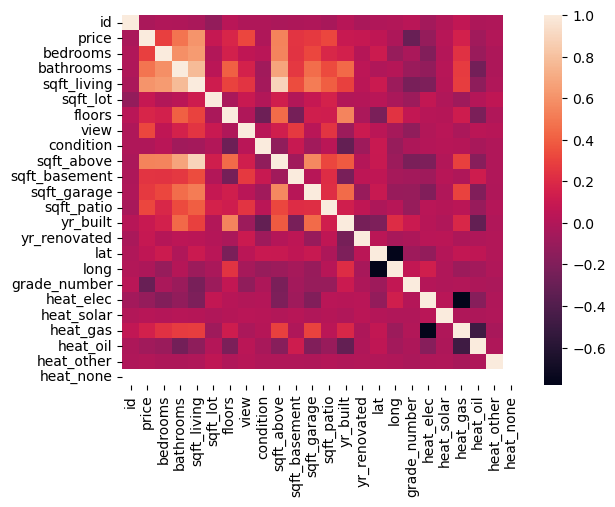

In [11]:
sns.heatmap(num_df.corr())
plt.show()

### Code for later to be used for getting dummies and performing OLS and fits

In [12]:
# y = df['price'].copy()
    
# X_ohe = pd.get_dummies(df.drop(['price'], axis=1), drop_first=False)

# all_mod = sm.OLS(y, sm.add_constant(X_ohe))

In [13]:
# all_results = all_mod.fit()
# print(all_results.summary())

# MAPS

## Continental USA Homes

(22.0, 53.0)

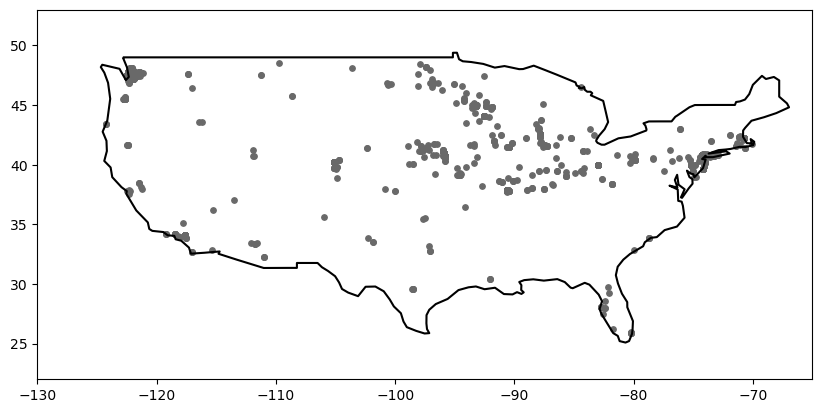

In [14]:
geometry_USA = gpd.points_from_xy(df.long, df.lat)                    # Setting the geometry points to be used

gdf_usa = GeoDataFrame(df[['lat', 'long']].copy(), geometry=geometry_USA) # Creating necessary GeoDataFrame

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))   # Accessing the map that comes with geopandas

usa_map = world[world['name'] == 'United States of America']          # Getting map data for USA only

ax = usa_map.boundary.plot(figsize=(10, 10), color='black')           # Setting ax for plotting boundary style map

gdf_usa.plot(ax=ax, marker='o', color='dimgray', markersize=15)           # Plotting the houses on the map as points

ax.set_aspect('equal', 'box')                                         # Setting aspect ratio (long/lat proportion)
ax.set_xlim((-130, -65))                                              # Setting x-limit
ax.set_ylim((22, 53))                                                 # Setting y-limit

## Washington Homes

Map shape source: https://github.com/joncutrer/geopandas-tutorial.git

In [15]:
# DataFrame of only Washington homes
wash_df = df[df['State'] == "Washington"]

EPSG:4326 EPSG:4326


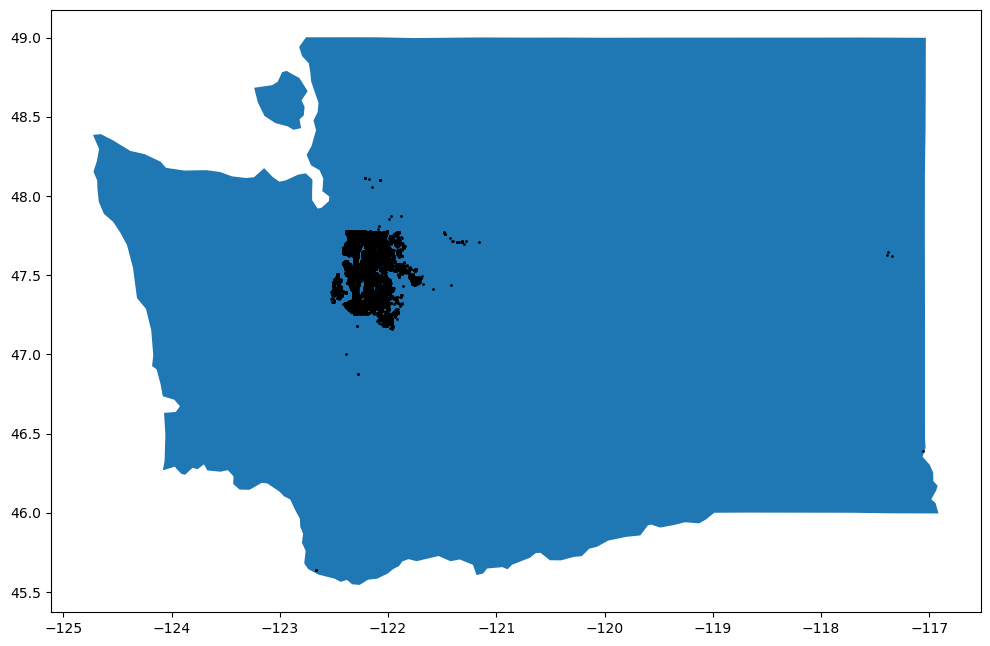

In [16]:
states = gpd.read_file('usa_data/usa-states-census-2014.shp')       # Read in USA map geometry data
w_state = states[states['NAME'] == 'Washington']                    # Get only Washington geometry
new_w_crs = w_state.crs                                             # Get coordinate system of Washington
ax = w_state.plot(figsize=(12,12))                                  # Plot Washington state
geometry_w = gpd.points_from_xy(wash_df.long, wash_df.lat)          # Create geometry of the Washington home data
gdf_w_homes = gpd.GeoDataFrame(wash_df, geometry=geometry_w)                # Create GeoDataFrame with home data and geometry
gdf_w_homes.set_crs(str(new_w_crs), inplace=True)                           # Apply correct coordinate system to home data
print(new_w_crs, gdf_w_homes.crs)                                           # Confirm identical coordinate systems
gdf_w_homes.plot(ax=ax, color='black', markersize=1)                        # Plot home data points onto Washington
plt.show()

## King County Homes

Map shape from census: https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html

Washington state FP is 53

#### UP NEXT

Use full dataframe in order to access everything by index instead of figuring out the reset_index stuff

Neighboring zip code relationship map colors

In [17]:
# Get the county data and add the geoseries for king county geometry
counties = gpd.read_file('usa_data/cb_2018_us_county_500k/cb_2018_us_county_500k.shp')

# County name is 'King' and State code STATEFP is 53 for Washington
king_geometry = counties.loc[(counties.NAME == 'King') & (counties.STATEFP == '53')].geometry

Function to get data from outside King County that needs to be removed.

In [18]:
# Function that takes GeoArray (a list of Point types) and checks if the point is in the county geometry
# Returns an array of Point s to keep, as well as a list of indexes to remove 
# (index according to list, not index name from the pandas dataframe, so reset_index is needed later)

def only_inside_county(points_list, county_geometry):
    rem_idx_list = []
    for idx, x in enumerate(points_list):
        if county_geometry.contains(x).values[0] == False:
            rem_idx_list.append(idx)
    new_points = np.delete(points_list, rem_idx_list)
    return new_points, rem_idx_list

EPSG:4269 EPSG:4269


<AxesSubplot:>

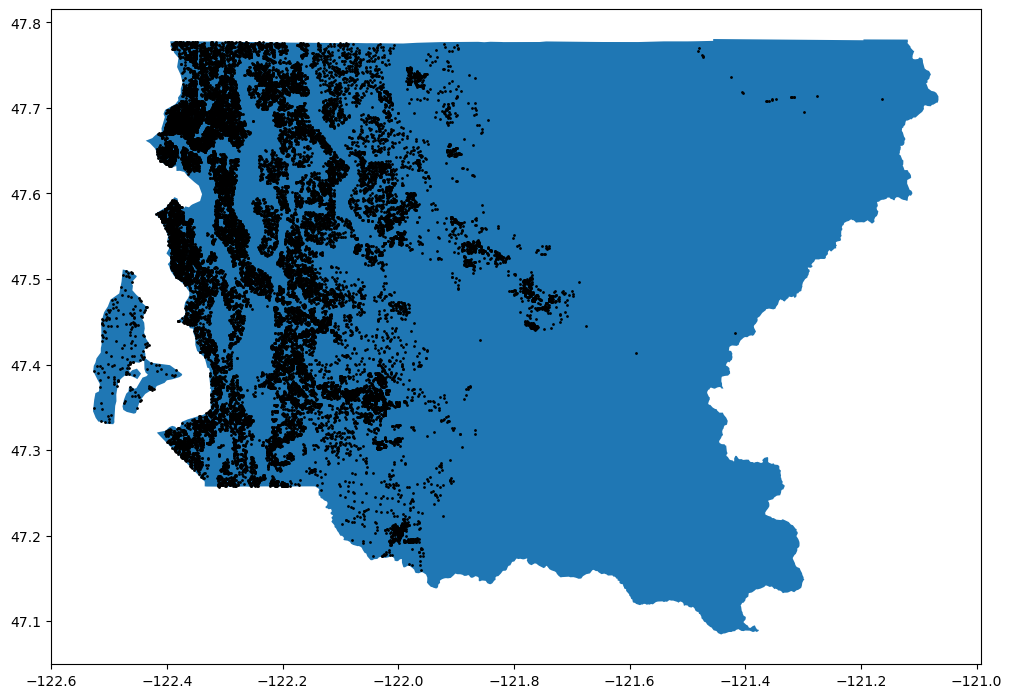

In [19]:
king_crs = king_geometry.crs                 # Get the coordinate system for king county
ax = king_geometry.plot(figsize=(12,12))     # Plot king county

geometry_k_homes = gpd.points_from_xy(wash_df.long, wash_df.lat)      # Convert WA home points to geoarray of Points
geometry_k_homes, rem_idxs = only_inside_county(geometry_k_homes, 
                                                king_geometry)        # Get the indexes to remove from geoarray

# Reset index of wash_df so that the indexes line up with indexes that need to be remoed from geoarray 'geometry'
# Then drop the indexes by index, instead of original index name by doing reset_index
gdf_k_homes = gpd.GeoDataFrame(wash_df.reset_index().drop(rem_idxs, axis=0, inplace=True), geometry=geometry_k_homes)

gdf_k_homes.set_crs(str(king_crs), inplace=True)     # Set new coordinate system for the data home points

print(king_crs, gdf_k_homes.crs)                     # Ensure coordinate systems are identical

gdf_k_homes.plot(ax=ax, color='black', markersize=1) # Plot the homes onto the county